# Pix2Pix GAN for Image-to-Image Translation

Video explanation: https://www.youtube.com/watch?v=UcHe0xiuvpg -> Absolute must watch!

In this notebook, we will implement the Pix2Pix GAN for image-to-image translation. The Pix2Pix GAN is a type of conditional GAN, where the generation of the output image is conditional on the input image. The Pix2Pix GAN is used for tasks such as image colorization, image super-resolution, and style transfer.

In [375]:
import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
import torch.optim as optim

In [376]:
# Discriminator for Pix2Pix
class DisCNNBlock(nn.Module):
    def __init__(self,in_channels, out_channels, stride):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.conv(x)
    
class Discriminator(nn.Module):
    def __init__(self, in_channels=3,features=[64,128,256,512]):
        super().__init__()

        self.first_block = nn.Sequential(
            nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                DisCNNBlock(in_channels,feature,stride=1 if feature==features[-1] else 2)
            )
            in_channels = feature

        # Add the last layer -> This layer will output a single value for each pixel in the image (real or fake)
        layers.append(
            nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1)
        )

        self.model = nn.Sequential(*layers)

    def forward(self,x,y):
        x = torch.cat([x,y],dim=1)
        x = self.first_block(x)
        x = self.model(x)
        return x

In [377]:
# Generator for Pix2Pix
class UNetBlock(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,2,1,bias=False,padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels,out_channels,4,2,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self,x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x
    
class Generator(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        # as per the paper we do not use batch normalization in the first layer
        self.first = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,4,2,1,padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        ) # 256x256 -> 128x128

        self.down1 = UNetBlock(out_channels,out_channels*2,down=True,act='leaky',use_dropout=False) # 128x128 -> 64x64
        self.down2 = UNetBlock(out_channels*2,out_channels*4,down=True,act='leaky',use_dropout=False) # 64x64 -> 32x32
        self.down3 = UNetBlock(out_channels*4,out_channels*8,down=True,act='leaky',use_dropout=False) # 32x32 -> 16x16
        self.down4 = UNetBlock(out_channels*8,out_channels*8,down=True,act='leaky',use_dropout=False) # 16x16 -> 8x8
        self.down5 = UNetBlock(out_channels*8,out_channels*8,down=True,act='leaky',use_dropout=False) # 8x8 -> 4x4
        self.down6 = UNetBlock(out_channels*8,out_channels*8,down=True,act='leaky',use_dropout=False) # 4x4 -> 2x2
        self.unet_base = nn.Sequential(
            nn.Conv2d(out_channels*8,out_channels*8,4,2,1),
            nn.ReLU()
        ) # 2x2 -> 1x1

        self.up1 = UNetBlock(out_channels*8,out_channels*8,down=False,act='relu',use_dropout=True) # 1x1 -> 2x2
        self.up2 = UNetBlock(out_channels*8*2,out_channels*8,down=False,act='relu',use_dropout=True) # 2x2 -> 4x4
        self.up3 = UNetBlock(out_channels*8*2,out_channels*8,down=False,act='relu',use_dropout=True) # 4x4 -> 8x8
        self.up4 = UNetBlock(out_channels*8*2,out_channels*8,down=False,act='relu',use_dropout=False) # 8x8 -> 16x16
        self.up5 = UNetBlock(out_channels*8*2,out_channels*4,down=False,act='relu',use_dropout=False) # 16x16 -> 32x32
        self.up6 = UNetBlock(out_channels*4*2,out_channels*2,down=False,act='relu',use_dropout=False) # 32x32 -> 64x64
        self.up7 = UNetBlock(out_channels*2*2,out_channels,down=False,act='relu',use_dropout=False) # 64x64 -> 128x128

        self.final = nn.Sequential(
            nn.ConvTranspose2d(out_channels*2,in_channels,4,2,1),
            nn.Tanh()
        ) # 128x128 -> 256x256

    def forward(self,x):
        d1 = self.first(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        unet_base = self.unet_base(d7)
        u1 = self.up1(unet_base)
        u2 = self.up2(torch.cat([u1,d7],dim=1))
        u3 = self.up3(torch.cat([u2,d6],dim=1))
        u4 = self.up4(torch.cat([u3,d5],dim=1))
        u5 = self.up5(torch.cat([u4,d4],dim=1))
        u5 = self.up5(torch.cat([u4,d4],dim=1))
        u6 = self.up6(torch.cat([u5,d3],dim=1))
        u7 = self.up7(torch.cat([u6,d2],dim=1))
        return self.final(torch.cat([u7,d1],dim=1))



In [378]:
# Test the models
def test():
    x = torch.randn((1,3,256,256))
    gen = Generator(3,64)
    dis = Discriminator(in_channels=3)
    assert gen(x).shape == x.shape
    assert dis(x,x).shape == (1,1,30,30)
    print("All tests passed")

if __name__ == "__main__":
    test()

All tests passed


In [379]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class MapDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
            transforms.Resize((256,256))
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_file = self.files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        img = np.array(Image.open(img_path).convert("RGB"))
        input_img = img[:, :600, :]
        target_img = img[:, 0:600, :]
        input_img = self.transform(input_img)
        target_img = self.transform(target_img)
        return input_img, target_img
    
def get_dataloader(root_dir, batch_size):
    dataset = MapDataset(root_dir)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [380]:
# Test the dataset
def test():
    loader = get_dataloader("../data/pix2pix/maps/maps/train",16)
    for x,y in loader:
        assert x.shape == (16,3,256,256) and y.shape == (16,3,256,256)
        break
    print("All tests passed")
        
if __name__ == "__main__":
    test()

All tests passed


In [381]:
# Hyperparameters
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 2e-4
batch_size = 16
num_epochs = 10
in_channels = 3
image_size = 256
out_channels = 64
lambda_recon = 200

In [382]:
# Initialize the models
gen = Generator(in_channels,out_channels).to(device)
dis = Discriminator(in_channels).to(device)

# Optimizers
opt_gen = optim.Adam(gen.parameters(),lr=lr,betas=(0.5,0.999))
opt_dis = optim.Adam(dis.parameters(),lr=lr,betas=(0.5,0.999))

# Loss function
criterion = nn.BCEWithLogitsLoss()
l1 = nn.L1Loss()

In [383]:
# Load the data
train_loader = get_dataloader("../data/pix2pix/maps/maps/train",batch_size)

In [384]:
# show the images
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def show_tensor_images(image_tensor, num_images=16, size=(3, 256, 256), nrow=3):
    image_shifted = image_tensor
    image_unflat = image_shifted.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.7103, Generator Loss: 132.5420


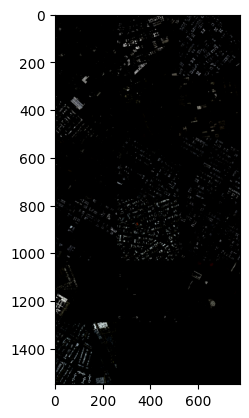

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.7496, Generator Loss: 109.7496


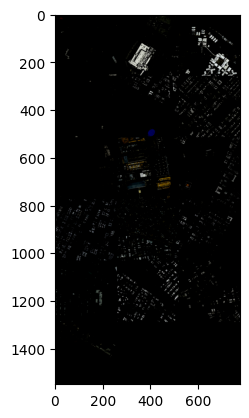

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.8893, Generator Loss: 97.5947


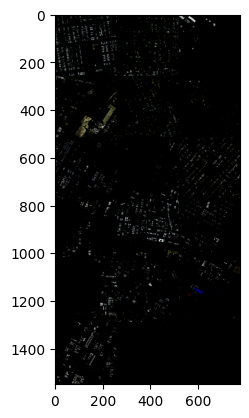

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.7087, Generator Loss: 84.7545


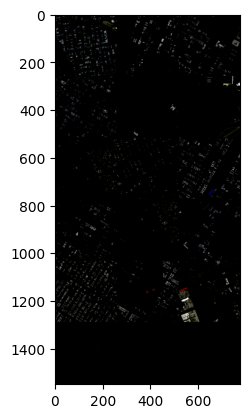

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6797, Generator Loss: 73.6763


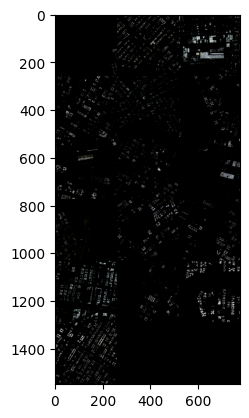

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6748, Generator Loss: 64.4500


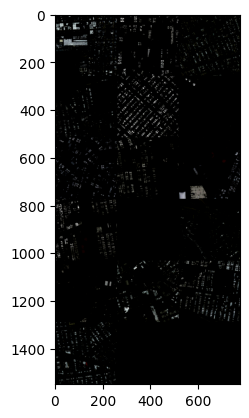

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6569, Generator Loss: 62.9799


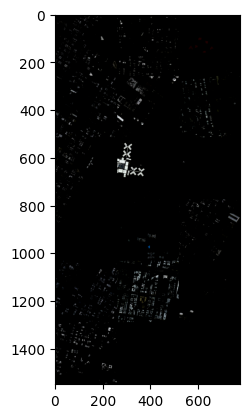

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6523, Generator Loss: 54.3911


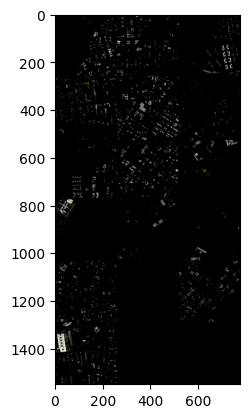

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6312, Generator Loss: 53.3491


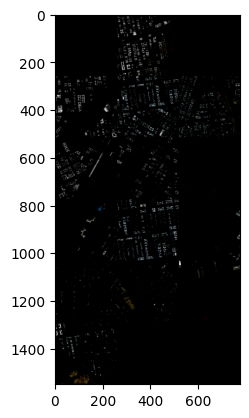

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6063, Generator Loss: 47.1596


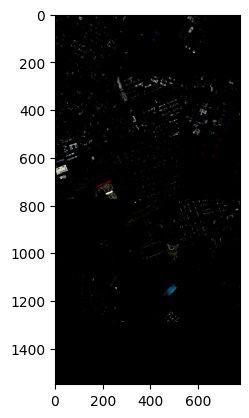

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5804, Generator Loss: 45.2220


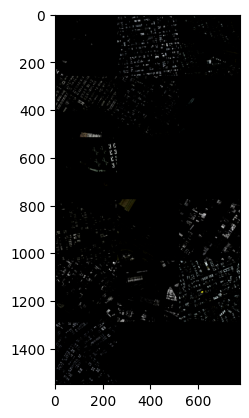

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5960, Generator Loss: 41.5783


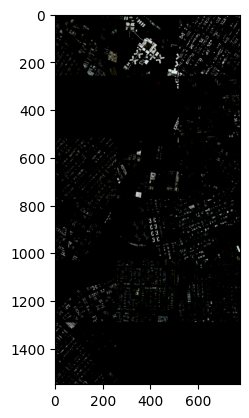

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5147, Generator Loss: 41.9369


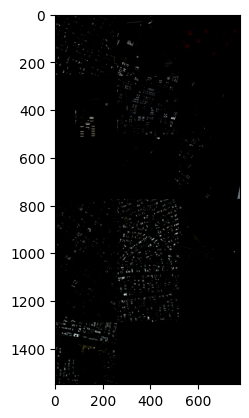

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5019, Generator Loss: 36.0651


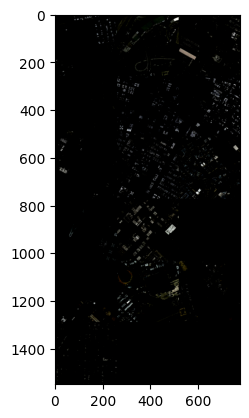

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5052, Generator Loss: 36.9564


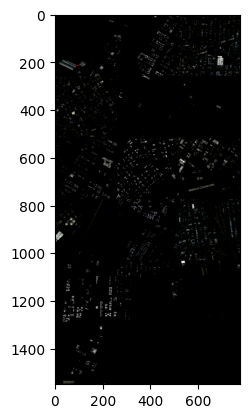

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.4538, Generator Loss: 34.6223


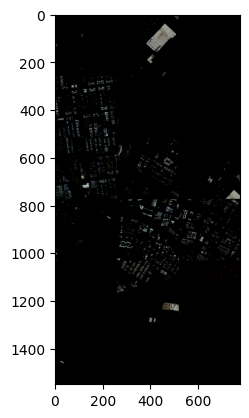

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5650, Generator Loss: 31.3207


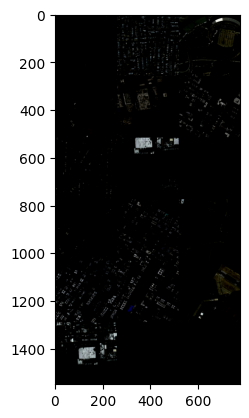

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.5692, Generator Loss: 35.7683


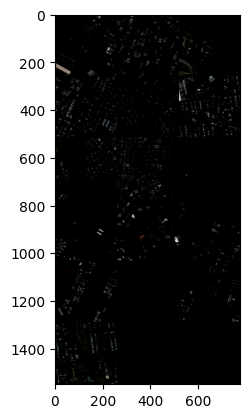

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.4876, Generator Loss: 29.2105


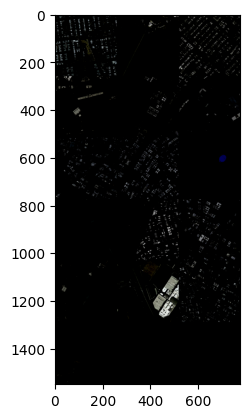

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.4401, Generator Loss: 32.9726


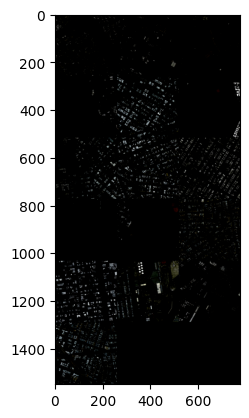

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.4089, Generator Loss: 27.7680


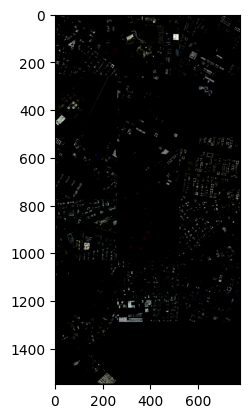

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3932, Generator Loss: 27.3298


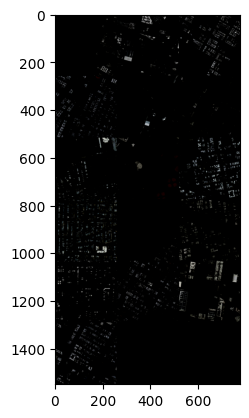

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3695, Generator Loss: 24.5908


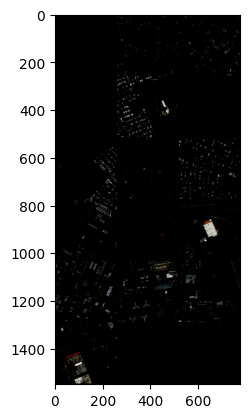

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3778, Generator Loss: 23.5505


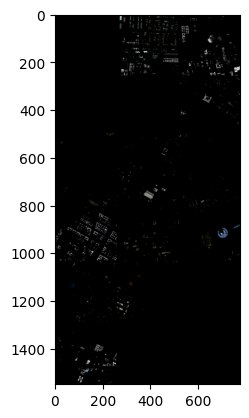

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3256, Generator Loss: 28.2015


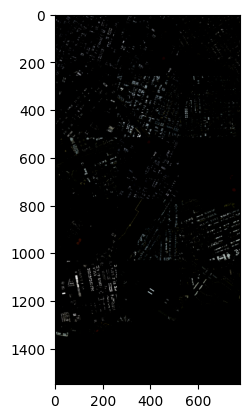

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3464, Generator Loss: 22.7972


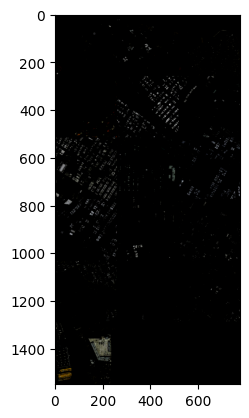

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3214, Generator Loss: 25.9351


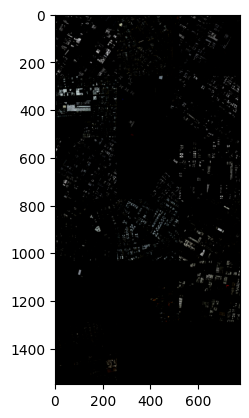

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.2556, Generator Loss: 22.5437


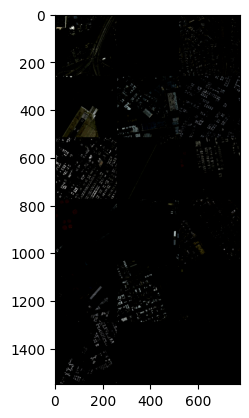

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.2327, Generator Loss: 23.5997


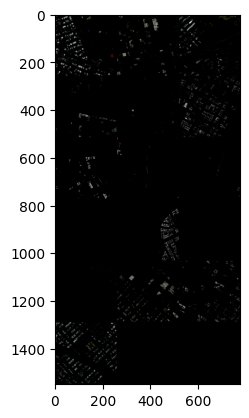

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3166, Generator Loss: 28.3207


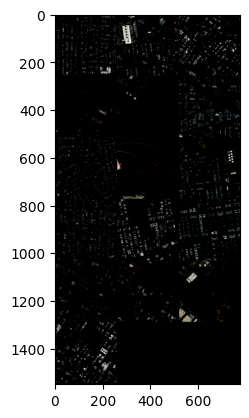

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.2526, Generator Loss: 21.9660


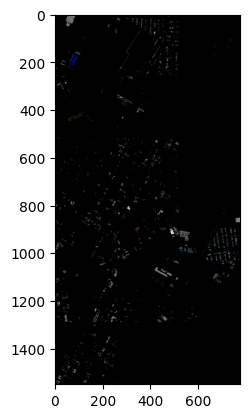

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1863, Generator Loss: 21.0826


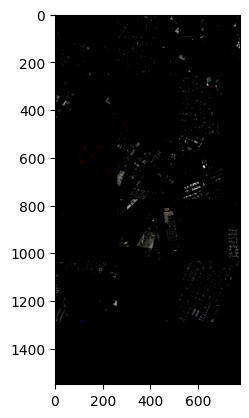

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1561, Generator Loss: 19.8093


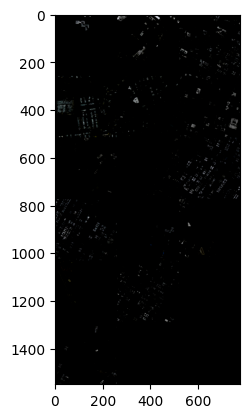

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1355, Generator Loss: 20.1793


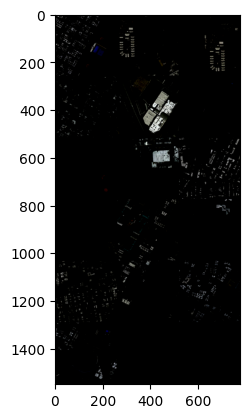

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1549, Generator Loss: 26.7142


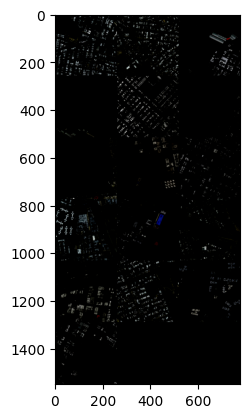

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1459, Generator Loss: 24.5621


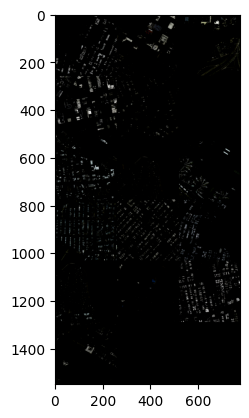

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1243, Generator Loss: 21.5986


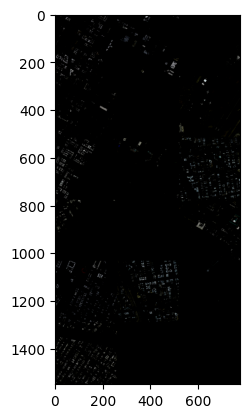

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1419, Generator Loss: 21.8063


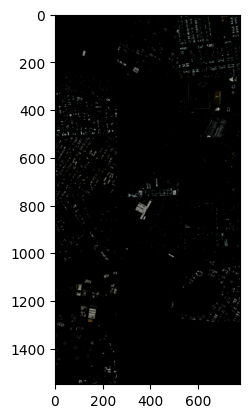

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1591, Generator Loss: 30.0065


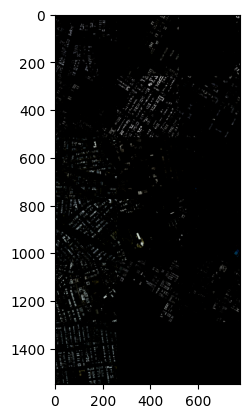

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.2116, Generator Loss: 22.5888


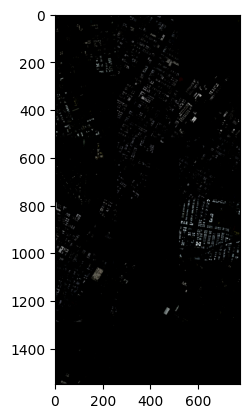

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.2235, Generator Loss: 23.6107


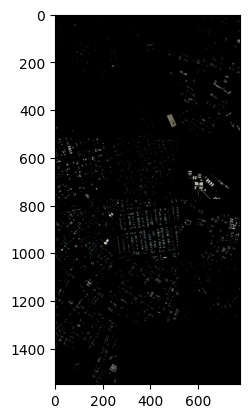

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.1714, Generator Loss: 19.4593


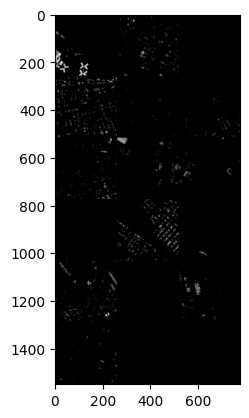

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.2472, Generator Loss: 19.9134


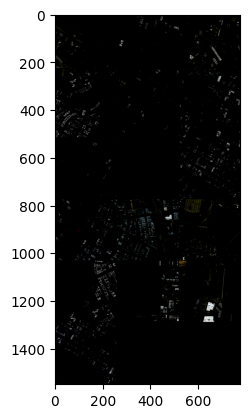

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3446, Generator Loss: 17.8121


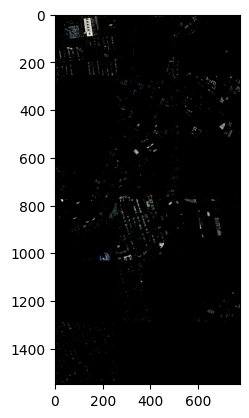

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3790, Generator Loss: 19.2362


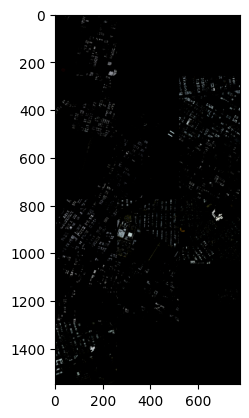

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.6984, Generator Loss: 18.2201


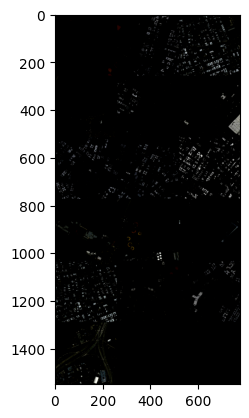

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch [0/10] Discriminator Loss: 0.3659, Generator Loss: 18.3921


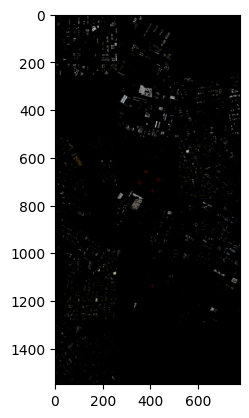

KeyboardInterrupt: 

In [385]:
# Training loop

generator_losses = []
discriminator_losses = []

def train():
    for epoch in range(num_epochs):
        for x,y in train_loader:
            x,y = x.to(device),y.to(device)
            fake = gen(x)
            # Train the discriminator
            real = dis(x,y)
            fake_pred = dis(x,fake.detach())
            real_loss = criterion(real,torch.ones_like(real))
            fake_loss = criterion(fake_pred,torch.zeros_like(fake_pred))
            dis_loss = (real_loss + fake_loss) / 2
            dis.zero_grad()
            dis_loss.backward()
            opt_dis.step()

            # Train the generator
            fake = gen(x)
            fake_pred = dis(x,fake)
            gen_loss = criterion(fake_pred,torch.ones_like(fake_pred))
            l1_loss = l1(fake,y) * lambda_recon
            gen_loss = gen_loss + l1_loss
            gen.zero_grad()
            gen_loss.backward()
            opt_gen.step()

            # Save the losses
            generator_losses.append(gen_loss.item())
            discriminator_losses.append(dis_loss.item())

            # Print the losses
            print(f"Epoch [{epoch}/{num_epochs}] Discriminator Loss: {dis_loss:.4f}, Generator Loss: {gen_loss:.4f}")

            # show the result after every 100 steps
            if epoch % 100 == 0:
                show_tensor_images(torch.cat([x,fake,y],dim=0))
                

if __name__ == "__main__":
    train()

# Save the model
torch.save(gen.state_dict(),"gen.pth")
torch.save(dis.state_dict(),"dis.pth")


In [ ]:
# Load the model
gen = Generator(in_channels,out_channels).to(device)
dis = Discriminator(in_channels).to(device)
gen.load_state_dict(torch.load("gen.pth"))
dis.load_state_dict(torch.load("dis.pth"))

# Generate the images
def generate():
    x,y = next(iter(train_loader))
    x,y = x.to(device),y.to(device)
    fake = gen(x)
    show_tensor_images(torch.cat([x,fake,y],dim=0))

if __name__ == "__main__":
    generate()

In [ ]:
# Plot the losses
plt.plot(generator_losses,label="Generator Loss")
plt.plot(discriminator_losses,label="Discriminator Loss")
plt.legend()
plt.show()